In [1]:
# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from collections import namedtuple
import math

In [2]:
import gdown
# resolution 1mx1m
gdown.download('https://drive.google.com/uc?export=download&id=1ufpAuAw8gXAlvDEnDxVNHuv_eOeACEqs')
# resolution 5mx5m
gdown.download('https://drive.google.com/uc?id=1ZICIK3FAoTnousekKUNxy6dUCGBffUOM&export=download')
# resolution 10mx10m
gdown.download('https://drive.google.com/uc?id=1qP52NQ1r5aYMlNWNPiu_ggqEJ4aA_EVJ&export=download')
# resolution 2mx2m
gdown.download('https://drive.google.com/uc?id=1FxbS7Q98y4-Q6vw6_tYfuHwpbUJEqTrS&export=download')


Downloading...
From: https://drive.google.com/uc?export=download&id=1ufpAuAw8gXAlvDEnDxVNHuv_eOeACEqs
To: /content/pgmimg_1.000000.pgm
100%|██████████| 6.24M/6.24M [00:00<00:00, 262MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZICIK3FAoTnousekKUNxy6dUCGBffUOM&export=download
To: /content/pgmimg_5.000000.pgm
100%|██████████| 249k/249k [00:00<00:00, 50.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qP52NQ1r5aYMlNWNPiu_ggqEJ4aA_EVJ&export=download
To: /content/pgmimg_10.000000.pgm
100%|██████████| 62.0k/62.0k [00:00<00:00, 73.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FxbS7Q98y4-Q6vw6_tYfuHwpbUJEqTrS&export=download
To: /content/pgmimg_2.000000.pgm
100%|██████████| 1.55M/1.55M [00:00<00:00, 92.1MB/s]


'pgmimg_2.000000.pgm'

In [3]:
class PerceptionMapper:
  def __init__(self, image, resolution):
    self.map = self.initialiseMap(image)
    # height, width
    self.size = self.map.shape
    self.defaultResolution = resolution

  def initialiseMap(self, testImage):
    env = np.ones(testImage.shape)
    for i in range(testImage.shape[0]):
      for j in range(testImage.shape[1]):
        if testImage[i][j] > 125:
          env[i][j] = 0
    # print(env.map[0][0])
    return env

In [4]:
if __name__ == "__main__":

  # Map is represented by a numpy array, with origin at top left corner
  # Positive X-axis is towards right
  # Positive Y-axis is towards bottom
  #  ----------> X
  #  |
  #  |
  #  |
  #  |
  #  |
  #  |
  #  V Y
  # map[y][x] will give you the occupancy value of the cell


  # Map of Rellis Campus with resolution of 1pixel = 4mt^2 (2x2)
    testImage1 = img.imread('pgmimg_2.000000.pgm')
    env1 = PerceptionMapper(testImage1, 2)
    map1 = env1.map

    # Map of Rellis Campus with resolution of 1pixel = 25mt^2 (5x5)
    testImage2 = img.imread('pgmimg_5.000000.pgm')
    env2 = PerceptionMapper(testImage2, 5)
    map2 = env2.map

    # Map of Rellis Campus with resolution of 1pixel = 100mt^2 (10x10)
    testImage3 = img.imread('pgmimg_10.000000.pgm')
    env3 = PerceptionMapper(testImage3, 10)
    map3 = env3.map

    # Map of Rellis Campus with resolution of 1pixel = 1mt^2 (1x1)
    testImage4 = img.imread('pgmimg_1.000000.pgm')
    env4 = PerceptionMapper(testImage4, 1)
    map4 = env4.map

In [5]:
import numpy as np
import pandas as pd
from queue import PriorityQueue
import time
import matplotlib.pyplot as plt
import math

OBSTACLE = 1
COST = 1


def lies_in_grid(node: tuple, occupancy_grid: list) -> bool:
    """
    Check if a node lies within the bounds of the occupancy grid.
    """
    num_rows = len(occupancy_grid)  # Get the number of rows in the occupancy grid.
    num_cols = len(occupancy_grid[0])  # Get the number of columns in the occupancy grid.

    return 0 <= node[0] < num_rows and 0 <= node[1] < num_cols


def check_obstacle(node: tuple, occupancy_grid: list) -> bool:
    """
    Check if a node is an obstacle in the occupancy grid.
    """
    return occupancy_grid[node[0]][node[1]] == OBSTACLE


def reconstruct_path(source_node: tuple, destination_node: tuple, came_from: dict) -> list:
    """
    Reconstruct the path from source to destination using the 'came_from' dictionary.
    """
    path = []  # Initialize an empty list called path.
    current = destination_node  # Set the current node to be the destination node.

    while current != source_node:  # While the current node is not the source node.
        path.append(current)  # Add the current node to the path.
        current = came_from[current]  # Set the current node to be its parent node.

    path.append(source_node)  # Add the source node to the path.
    path.reverse()  # Reverse the path to get it in the correct order.
    return path  # Return the reconstructed path.


def plot_map(occupancy_grid: list, path: list, source_node: tuple, destination_node: tuple):
    """
    Plot the grid map with the path, source node, and goal node.
    """
    fig, ax = plt.subplots()

    #displaying the occupancy grid
    map_np = np.array(occupancy_grid)
    ax.imshow(map_np)

    #displaying the path on occupancy grid
    path_np = np.array(path)
    ax.plot(path_np[:, 1], path_np[:, 0], marker='o', color='pink', markersize=0.5, linewidth=0.5)

    ax.plot(source_node[1], source_node[0], marker='s', color='green', markersize=2, label='source_node')
    ax.plot(destination_node[1], destination_node[0], marker='s', color='red', markersize=2, label='destination_node')
    ax.legend()  # Add a legend.
    plt.show()  # Display the plot.


def get_adjusted_pos(source_node: tuple, destination_node: tuple, resolution: float) -> tuple:
    """
    Adjust the source and destination positions based on the resolution.
    """
    start1 = int(source_node[0] / resolution)
    start2 = int(source_node[1] / resolution)
    start = (start1, start2)

    goal1 = int(destination_node[0] / resolution)
    goal2 = int(destination_node[1] / resolution)
    goal = (goal1, goal2)

    return start, goal


def find_shortest_path_dijkstra(occupancy_grid: list, movements: list, source_node: tuple, destination_node: tuple) -> tuple:
    """
    Find the shortest path using Dijkstra's algorithm.
    """
    #Initialize the g_score dictionary with infinite values and Set the g_score for the source node to 0
    g_score = {(i, j): float('inf') for i in range(len(occupancy_grid)) for j in range(len(occupancy_grid[0]))}
    g_score[source_node] = 0

    #Create a priority queue and put the source node in the priority queue with a priority of 0
    priority_queue = PriorityQueue()
    priority_queue.put((0, source_node))

    # Initialize an empty list to keep track of searched nodes
    searched_nodes = []

    # Initialize an empty dictionary to store parent-child relationships
    came_from = {}

    while not priority_queue.empty():  # While the priority queue is not empty.
        current_g, current_node = priority_queue.get()  # Get the node with the highest priority.
        searched_nodes.append(current_node)  # Add the current node to the list of searched nodes.


        # If the current node is the destination node, return the reconstructed path and the list of searched nodes
        if current_node == destination_node:
            return reconstruct_path(source_node, destination_node, came_from), searched_nodes

        # For each possible movement, calculate the new node.
        for dy, dx in movements:
            new_node = (current_node[0] + dy, current_node[1] + dx)

            # If the new node is within the grid bounds and not an obstacle, calculate the new g_score.
            if lies_in_grid(new_node, occupancy_grid) and not check_obstacle(new_node, occupancy_grid):
                new_g = current_g + COST

                if new_g < g_score[new_node]:  # If the new g_score is less than the existing g_score for the node.
                    came_from[new_node] = current_node  # Update the parent-child relationship.
                    g_score[new_node] = new_g  # Update the g_score.
                    priority_queue.put((new_g, new_node))  # Put the node back in the priority queue with the updated priority.

    return None, searched_nodes  # Return None for path (if unsearched destination node) and the list of searched nodes


def heuristic_cost_estimate(current_node: tuple, destination_node: tuple) -> int:
    """
    Heuristic cost estimate for A* algorithm.
    """
    return abs(((current_node[0] - destination_node[0])**2 + (current_node[1] - destination_node[1])**2))


def find_shortest_path_astar(occupancy_grid: list, movements: list, source_node: tuple, destination_node: tuple) -> tuple:
    """
    Find the shortest path using A* algorithm.
    """
    #Initialize the g_score dictionary with infinite values and Set the g_score for the source node to 0
    g_score = {(i,j):float('inf') for i in range(len(occupancy_grid)) for j in range(len(occupancy_grid[0]))}
    g_score[source_node] = 0

    #Initialize the f_score dictionary with infinite values and Set the f_score for the source node using heuristic estimate
    f_score = {(i,j):float('inf') for i in range(len(occupancy_grid)) for j in range(len(occupancy_grid[0]))}
    f_score[source_node] = heuristic_cost_estimate(source_node, destination_node)

    #Create a priority queue and put the source node in the priority queue with priority based on f_score and heuristic estimate.
    priority_queue = PriorityQueue()
    priority_queue.put((f_score[source_node], heuristic_cost_estimate(source_node, destination_node), source_node))

    # Initialize an empty list to keep track of searched nodes
    searched_nodes = []

    # Initialize an empty dictionary to store parent-child relationships
    came_from = {}

    while not priority_queue.empty():  # While the priority queue is not empty.
        _,_, current_node = priority_queue.get()  # Get the node with the highest priority.
        searched_nodes.append(current_node)  # Add the current node to the list of searched nodes.

        # If the current node is the destination node, return the reconstructed path and the list of searched nodes
        if current_node == destination_node:
            return reconstruct_path(source_node, destination_node, came_from), searched_nodes

        # For each possible movement, calculate the new node.
        for dy, dx in movements:
            new_node = (current_node[0] + dy, current_node[1] + dx)

            # If the new node is within the grid bounds and not an obstacle, calculate the temp g_score and temp f_score.
            if lies_in_grid(new_node, occupancy_grid) and not check_obstacle(new_node, occupancy_grid):
                temp_g_score = g_score[current_node] + COST
                temp_f_score = temp_g_score + heuristic_cost_estimate(new_node, destination_node)

                # If the temporary f_score is less than the existing f_score for the node.
                if temp_f_score < f_score[new_node]:
                    came_from[new_node] = current_node  # Update the parent-child relationship.
                    g_score[new_node] = temp_g_score  # Update the g_score.
                    f_score[new_node] = temp_f_score  # Update the f_score.
                    priority_queue.put((temp_f_score, heuristic_cost_estimate(new_node, destination_node), new_node))  # Put the node back in the priority queue with the updated priority.


    return None, searched_nodes  # Return None for path (if unsearched destination node) and the list of searched nodes


Computation time to get path from (158, 224) to (1468, 232) in map1 (2.0 m * 2.0 m) for Dijkstra is 1.6699540615081787


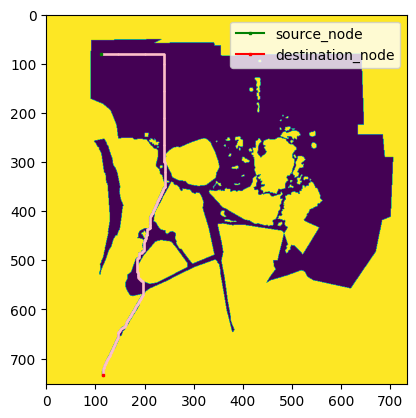

Computation time to get path from (158, 224) to (1468, 232) in map1 (2.0 m * 2.0 m) for A* is 0.5101418495178223


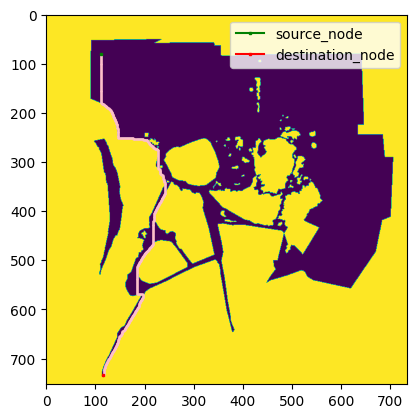

Computation time to get path from (158, 224) to (870, 964) in map1 (2.0 m * 2.0 m) for Dijkstra is 1.4209530353546143


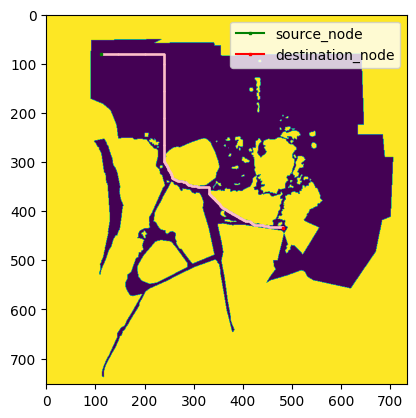

Computation time to get path from (158, 224) to (870, 964) in map1 (2.0 m * 2.0 m) for A* is 1.6094310283660889


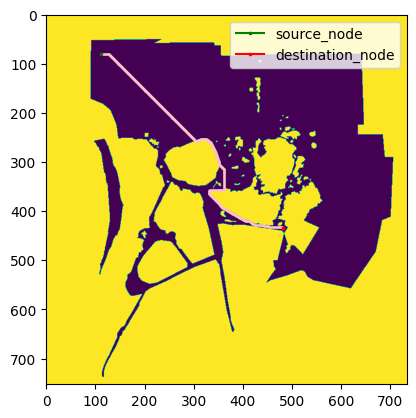

start/goal position is occupied. Hence, No solution
Unreachable Destination Node. Hence, no path could be found by dijkstra between (158, 224) to (840, 274) in map1 (2.0 m * 2.0 m)
Unreachable Destination Node. Hence, no path could be found by A* between (158, 224) to (840, 274) in map1 (2.0 m * 2.0 m)
Computation time to get path from (892, 436) to (1468, 232) in map1 (2.0 m * 2.0 m) for Dijkstra is 0.7265987396240234


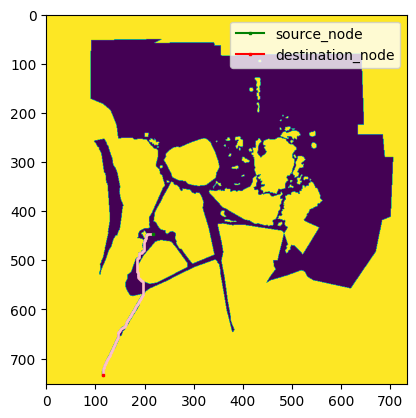

Computation time to get path from (892, 436) to (1468, 232) in map1 (2.0 m * 2.0 m) for A* is 0.47205471992492676


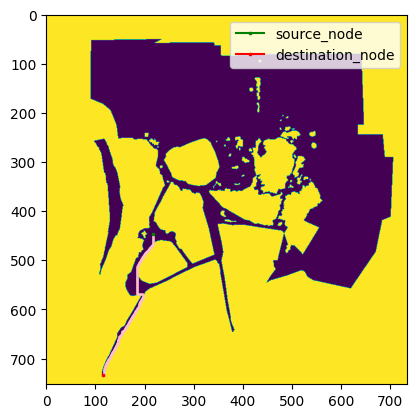

Computation time to get path from (892, 436) to (870, 964) in map1 (2.0 m * 2.0 m) for Dijkstra is 0.7475173473358154


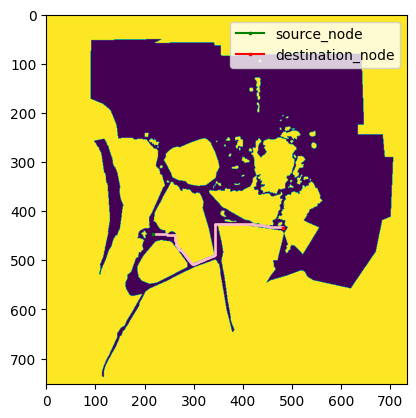

Computation time to get path from (892, 436) to (870, 964) in map1 (2.0 m * 2.0 m) for A* is 0.4590630531311035


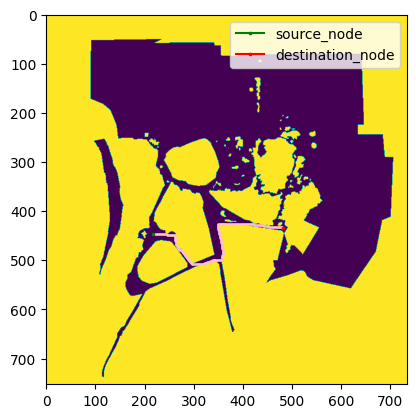

start/goal position is occupied. Hence, No solution
Unreachable Destination Node. Hence, no path could be found by dijkstra between (892, 436) to (840, 274) in map1 (2.0 m * 2.0 m)
Unreachable Destination Node. Hence, no path could be found by A* between (892, 436) to (840, 274) in map1 (2.0 m * 2.0 m)
Computation time to get path from (158, 224) to (1468, 232) in map2 (5.0 m * 5.0 m) for Dijkstra is 0.2538936138153076


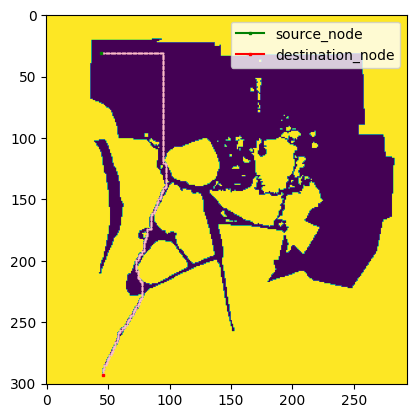

Computation time to get path from (158, 224) to (1468, 232) in map2 (5.0 m * 5.0 m) for A* is 0.07737350463867188


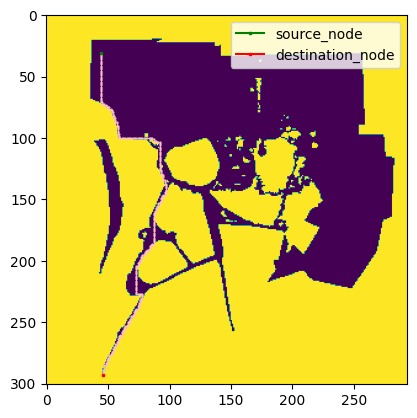

Computation time to get path from (158, 224) to (870, 964) in map2 (5.0 m * 5.0 m) for Dijkstra is 0.20654702186584473


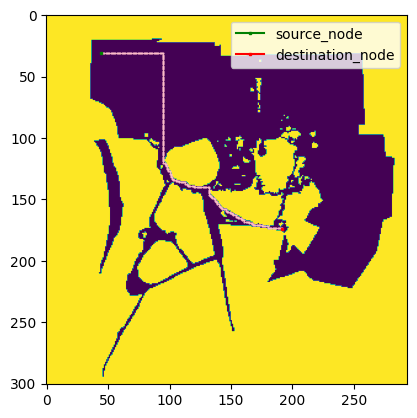

Computation time to get path from (158, 224) to (870, 964) in map2 (5.0 m * 5.0 m) for A* is 0.1161355972290039


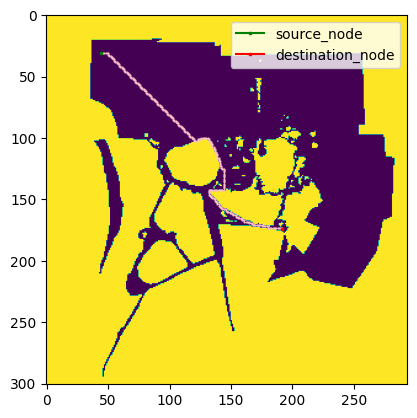

start/goal position is occupied. Hence, No solution
Unreachable Destination Node. Hence, no path could be found by dijkstra between (158, 224) to (840, 274) in map2 (5.0 m * 5.0 m)
Unreachable Destination Node. Hence, no path could be found by A* between (158, 224) to (840, 274) in map2 (5.0 m * 5.0 m)
Computation time to get path from (892, 436) to (1468, 232) in map2 (5.0 m * 5.0 m) for Dijkstra is 0.10201859474182129


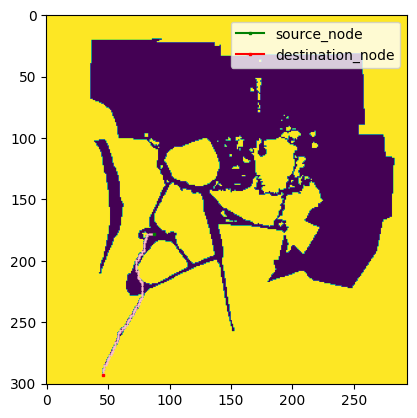

Computation time to get path from (892, 436) to (1468, 232) in map2 (5.0 m * 5.0 m) for A* is 0.0738532543182373


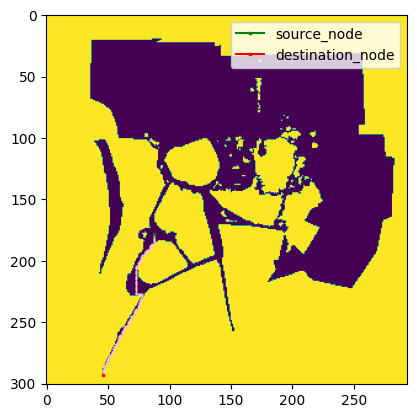

Computation time to get path from (892, 436) to (870, 964) in map2 (5.0 m * 5.0 m) for Dijkstra is 0.1197662353515625


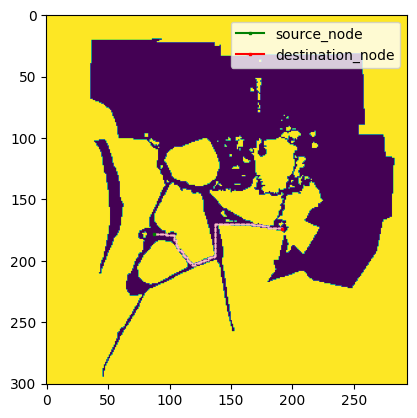

Computation time to get path from (892, 436) to (870, 964) in map2 (5.0 m * 5.0 m) for A* is 0.0797109603881836


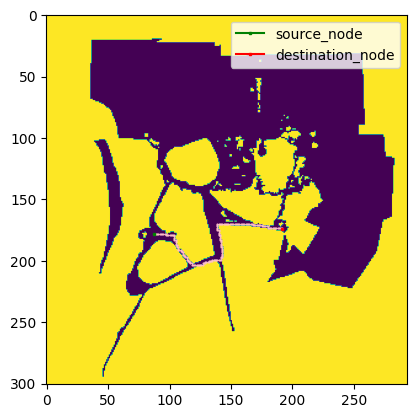

start/goal position is occupied. Hence, No solution
Unreachable Destination Node. Hence, no path could be found by dijkstra between (892, 436) to (840, 274) in map2 (5.0 m * 5.0 m)
Unreachable Destination Node. Hence, no path could be found by A* between (892, 436) to (840, 274) in map2 (5.0 m * 5.0 m)
Unreachable Destination Node. Hence, no path could be found by dijkstra between (158, 224) to (1468, 232) in map3 (10.0 m * 10.0 m)
Unreachable Destination Node. Hence, no path could be found by A* between (158, 224) to (1468, 232) in map3 (10.0 m * 10.0 m)
Computation time to get path from (158, 224) to (870, 964) in map3 (10.0 m * 10.0 m) for Dijkstra is 0.04608297348022461


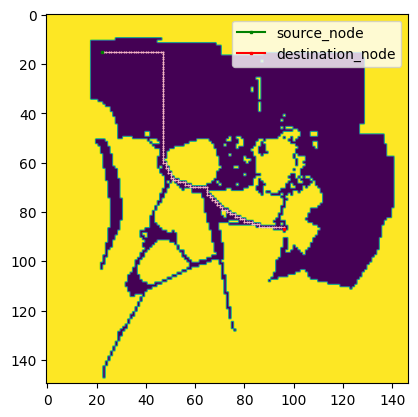

Computation time to get path from (158, 224) to (870, 964) in map3 (10.0 m * 10.0 m) for A* is 0.0329132080078125


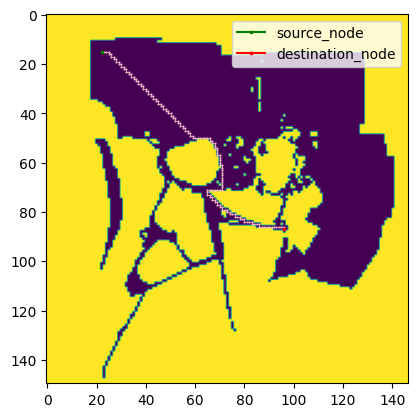

start/goal position is occupied. Hence, No solution
Unreachable Destination Node. Hence, no path could be found by dijkstra between (158, 224) to (840, 274) in map3 (10.0 m * 10.0 m)
Unreachable Destination Node. Hence, no path could be found by A* between (158, 224) to (840, 274) in map3 (10.0 m * 10.0 m)
Unreachable Destination Node. Hence, no path could be found by dijkstra between (892, 436) to (1468, 232) in map3 (10.0 m * 10.0 m)
Unreachable Destination Node. Hence, no path could be found by A* between (892, 436) to (1468, 232) in map3 (10.0 m * 10.0 m)
Unreachable Destination Node. Hence, no path could be found by dijkstra between (892, 436) to (870, 964) in map3 (10.0 m * 10.0 m)
Unreachable Destination Node. Hence, no path could be found by A* between (892, 436) to (870, 964) in map3 (10.0 m * 10.0 m)
start/goal position is occupied. Hence, No solution
Unreachable Destination Node. Hence, no path could be found by dijkstra between (892, 436) to (840, 274) in map3 (10.0 m * 10.

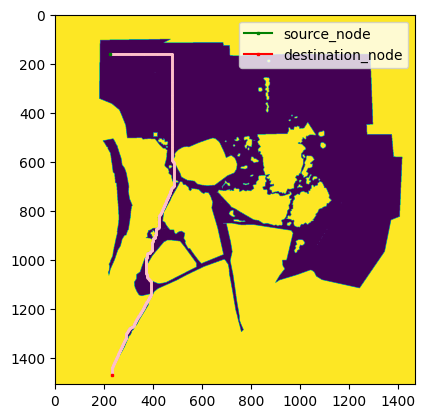

Computation time to get path from (158, 224) to (1468, 232) in map4 (1.0 m * 1.0 m) for A* is 4.34710693359375


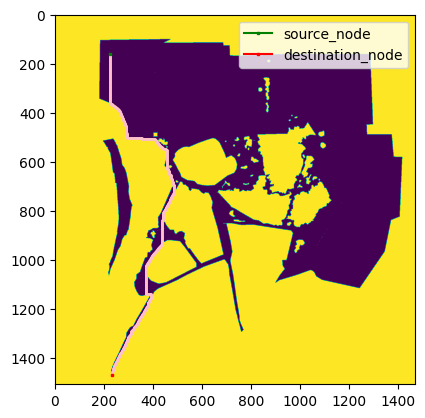

Computation time to get path from (158, 224) to (870, 964) in map4 (1.0 m * 1.0 m) for Dijkstra is 7.035702228546143


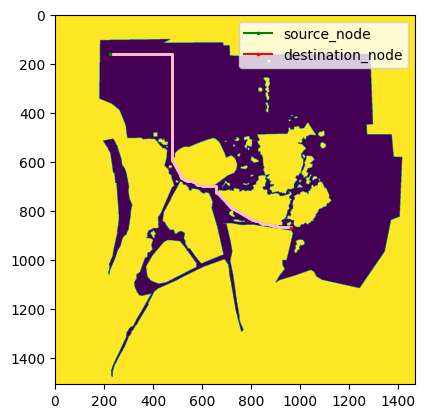

Computation time to get path from (158, 224) to (870, 964) in map4 (1.0 m * 1.0 m) for A* is 7.525381326675415


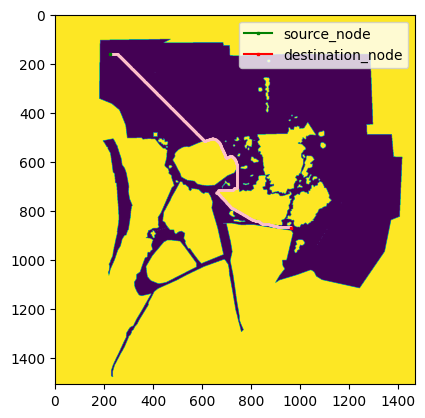

start/goal position is occupied. Hence, No solution
Unreachable Destination Node. Hence, no path could be found by dijkstra between (158, 224) to (840, 274) in map4 (1.0 m * 1.0 m)
Unreachable Destination Node. Hence, no path could be found by A* between (158, 224) to (840, 274) in map4 (1.0 m * 1.0 m)
Computation time to get path from (892, 436) to (1468, 232) in map4 (1.0 m * 1.0 m) for Dijkstra is 3.1664798259735107


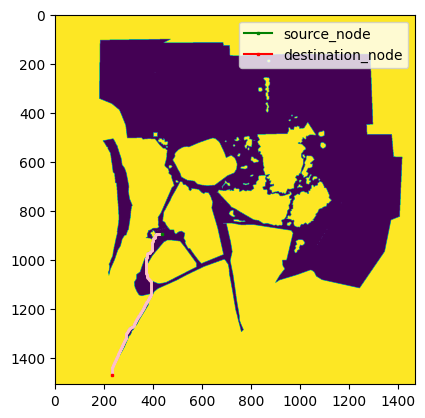

Computation time to get path from (892, 436) to (1468, 232) in map4 (1.0 m * 1.0 m) for A* is 2.6768195629119873


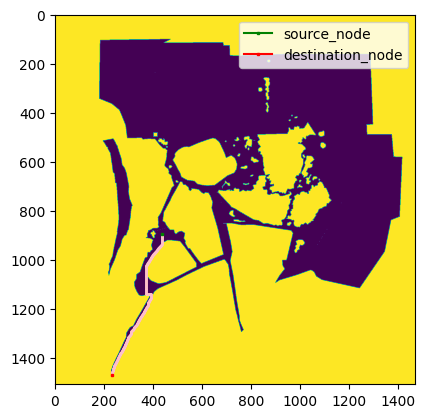

Computation time to get path from (892, 436) to (870, 964) in map4 (1.0 m * 1.0 m) for Dijkstra is 3.1641688346862793


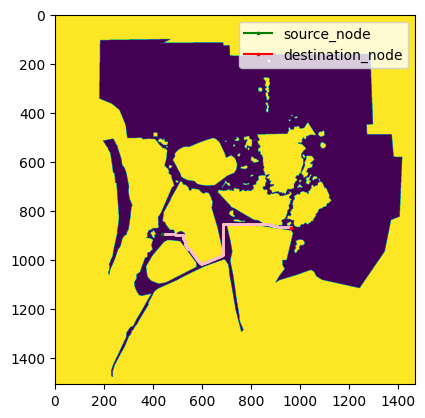

Computation time to get path from (892, 436) to (870, 964) in map4 (1.0 m * 1.0 m) for A* is 2.247886896133423


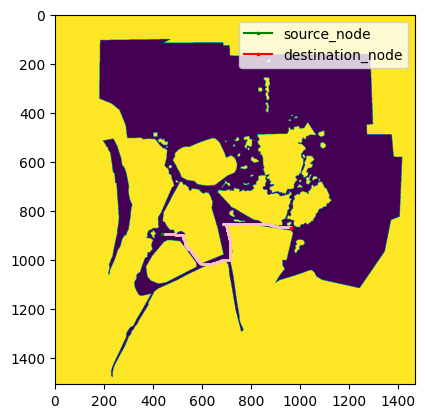

start/goal position is occupied. Hence, No solution
Unreachable Destination Node. Hence, no path could be found by dijkstra between (892, 436) to (840, 274) in map4 (1.0 m * 1.0 m)
Unreachable Destination Node. Hence, no path could be found by A* between (892, 436) to (840, 274) in map4 (1.0 m * 1.0 m)


In [6]:
# Define source and destination nodes
source_nodes = [(158, 224), (892, 436)]
destination_nodes = [(1468, 232), (870, 964), (72, 304), (840, 274)]

movements = [(0, 1),  # right
             (0, -1),  # left
             (1, 0),  # down
             (-1, 0)]  # up

results_list = []

maps = [map1, map2, map3, map4]
res = [2.0, 5.0, 10.0, 1.0]

# Loop through each map and its corresponding resolution
for i, selected_map in enumerate(maps):

    # Loop through each combination of source and target nodes
    for source in source_nodes:
        for destination in destination_nodes:

            # Get adjusted positions based on resolution
            start, goal = get_adjusted_pos(source, destination, res[i])

            grid_matrix = selected_map.tolist()

            # Check if start or goal positions are obstacles
            if check_obstacle(start, grid_matrix) or check_obstacle(goal, grid_matrix):
                print("start/goal position is occupied. Hence, No solution")

                results_list.append({
                    'map_num': f"map{i + 1}",
                    'resolution': f"{res[i]} m * {res[i]} m",
                    'source': source,
                    'destination': destination,
                    'computation time (dijkstra)': None,
                    'total_searched(dijkstra)': None,
                    'computation time (astar)': None,
                    'total_searched(astar)': None
                })

            else:
                # find path using Dijkstra's algorithm
                x = time.time()
                path_dijkstra, searched_nodes_dijkstra = find_shortest_path_dijkstra(grid_matrix, movements, start, goal)
                total_time_dijkstra = time.time() - x
                total_searched_nodes_dijkstra = len(searched_nodes_dijkstra)

                if path_dijkstra is None:
                    computation_time_dijkstra = "N/A"
                    print(f"Unreachable Destination Node. Hence, no path could be found by dijkstra between {source} to {destination} in map{i + 1} ({res[i]} m * {res[i]} m)")

                else:
                    computation_time_dijkstra = total_time_dijkstra
                    print(f"Computation time to get path from {source} to {destination} in map{i + 1} ({res[i]} m * {res[i]} m) for Dijkstra is {computation_time_dijkstra}")
                    plot_map(grid_matrix, path_dijkstra, start, goal)

                # find path using A* algorithm
                x = time.time()
                path_astar, searched_nodes_astar = find_shortest_path_astar(grid_matrix, movements, start, goal)
                total_time_astar = time.time() - x
                total_searched_nodes_astar = len(searched_nodes_astar)

                if path_astar is None:
                    computation_time_astar = "N/A"
                    print(f"Unreachable Destination Node. Hence, no path could be found by A* between {source} to {destination} in map{i + 1} ({res[i]} m * {res[i]} m)")

                else:
                    computation_time_astar = total_time_astar
                    print(f"Computation time to get path from {source} to {destination} in map{i + 1} ({res[i]} m * {res[i]} m) for A* is {computation_time_astar}")
                    plot_map(grid_matrix, path_astar, start, goal)

                results_list.append({
                    'map_num': f"map{i + 1}",
                    'resolution': f"{res[i]} m * {res[i]} m",
                    'source': source,
                    'destination': destination,
                    'computation time (dijkstra)': computation_time_dijkstra,
                    'total_searched(dijkstra)': total_searched_nodes_dijkstra,
                    'computation time (astar)': computation_time_astar,
                    'total_searched(astar)': total_searched_nodes_astar
                })

# Create a DataFrame from the results_list
results_df = pd.DataFrame(results_list)

file_path = 'results.csv'
results_df.to_csv(file_path, index=False)

In [7]:
results_df

,map_num,resolution,source,destination,computation time (dijkstra),total_searched(dijkstra),computation time (astar),total_searched(astar)
0,map1,2.0 m * 2.0 m,"(158, 224)","(1468, 232)",1.669954,167302.0,0.510142,2039.0
1,map1,2.0 m * 2.0 m,"(158, 224)","(870, 964)",1.420953,132249.0,1.609431,42445.0
2,map1,2.0 m * 2.0 m,"(158, 224)","(72, 304)",None,NaN,None,NaN
3,map1,2.0 m * 2.0 m,"(158, 224)","(840, 274)",N/A,173126.0,N/A,275983.0
4,map1,2.0 m * 2.0 m,"(892, 436)","(1468, 232)",0.726599,57413.0,0.472055,1301.0
5,map1,2.0 m * 2.0 m,"(892, 436)","(870, 964)",0.747517,59813.0,0.459063,807.0
6,map1,2.0 m * 2.0 m,"(892, 436)","(72, 304)",None,NaN,None,NaN
7,map1,2.0 m * 2.0 m,"(892, 436)","(840, 274)",N/A,173126.0,N/A,200342.0
8,map2,5.0 m * 5.0 m,"(158, 224)","(1468, 232)",0.253894,26855.0,0.077374,565.0
9,map2,5.0 m * 5.0 m,"(158, 224)","(870, 964)",0.206547,21087.0,0.116136,3663.0
